In [1]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob

import tensorflow as tf

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam, Adam, SGD


In [2]:
# index-class mapping
MAP_CLASSES = {
    0: 'state1', 1: 'state2', 2: 'state3'
}

# img size standardized to 64x64
IMG_SIZE = 64

In [3]:
def load_train_set(dirname, map_classes, verbose=True):
    """Load train images.
    
    Use opencv to resize the images.
    
    Args:
        dirname: directory to read data from (one folder per class)
        map_classes: mapping variables e.g. {0: 'class_1, 1: 'class_2'}
        verbose: print info at the end
     
    Returns:
        X, y: X is an array with all the images resized
              y is an array with the labels
    """
    X_train = []
    y_train = []
    for label, class_name in map_classes.items():
        # print(label)
        files = os.listdir(os.path.join(dirname, class_name))
        # print(files)
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Reading {} train images for class {}".format(len(images), class_name))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, class_name, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_classes, verbose=True):
    """ Equivalent as above function, but imaged do not have to be in class folders
        Label is taken from file name e.g. on_0.jpg, off_3.jpg
    """
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_classes.items()}
    ## print(reverse_dict)
    for filename in glob.glob(dirname + '/*.*'):
    #for filename in glob.glob('dataset/test/**/*.jpg'):
        class_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        # print(class_name)
        if class_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[class_name])
    if verbose:
        print("Reading {} test pictures".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [5]:
DATASET_TRAIN_PATH = "dataset/train"
DATASET_TEST_PATH = "dataset/test"

X, y = load_train_set(DATASET_TRAIN_PATH, MAP_CLASSES)
X_t, y_t = load_test_set(DATASET_TEST_PATH, MAP_CLASSES)

Reading 750 train images for class state1
Reading 750 train images for class state2
Reading 750 train images for class state3
Reading 750 test pictures


In [6]:
# Shuffle data since images are read sequentially
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [7]:
def plot_acc(history, title="Model Accuracy"):
    """Plots accuracy per epoch"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Plots loss per epoch"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compares 2 train losses"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compares 2 train accuracies"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# To change plot size
# matplotlib.rcParams['figure.figsize'] = [8, 8]

In [139]:
X.shape

(2250, 64, 64, 3)

In [140]:
y.shape

(2250,)

In [141]:
print('State of button ', y[4], ' is ', MAP_CLASSES[y[4]])

State of button  0  is  state1


In [142]:
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

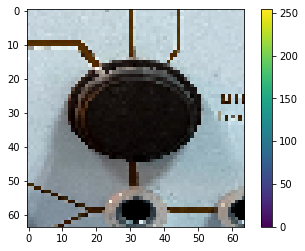

In [143]:
visualize_example(X[4])

In [8]:
# pixel normalization
X = X / 255.0
X_t = X_t / 255.0

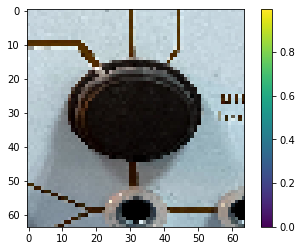

In [145]:
visualize_example(X[4])

In [9]:
batch_size = 64
num_classes = 3

In [147]:
y

array([2, 1, 1, ..., 2, 1, 1])

In [10]:
# Data preparation
y = tf.keras.utils.to_categorical(y, num_classes)
y_t = tf.keras.utils.to_categorical(y_t, num_classes)

X = X.astype('float32')
X_t = X_t.astype('float32')

In [149]:
y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [150]:
X_t.shape

(750, 64, 64, 3)

In [151]:
y_t.shape

(750, 3)

## Model

In [152]:
lr = 0.001
epochs = 40

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))   ### ADDED
model.add(MaxPooling2D((2, 2)))                                                                      ### ADDED
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

# compile model
# opt = SGD(lr=lr, momentum=0.9)
opt = Nadam(lr=lr)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/


In [153]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)        

In [154]:
mc = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

# 20% validation from train data
history = model.fit(X, y,
                   batch_size = batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split = 0.2,
                   callbacks=[mc])

Epoch 1/40
29/29 [==============================] - 8s 237ms/step - loss: 1.8124 - accuracy: 0.5416 - val_loss: 0.2068 - val_accuracy: 0.9333

Epoch 00001: val_loss improved from inf to 0.20684, saving model to best_model.h5
Epoch 2/40
29/29 [==============================] - 7s 235ms/step - loss: 0.1418 - accuracy: 0.9622 - val_loss: 0.0181 - val_accuracy: 0.9978

Epoch 00002: val_loss improved from 0.20684 to 0.01810, saving model to best_model.h5
Epoch 3/40
29/29 [==============================] - 7s 236ms/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 0.0031 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.01810 to 0.00314, saving model to best_model.h5
Epoch 4/40
29/29 [==============================] - 7s 233ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00314 to 0.00195, saving model to best_model.h5
Epoch 5/40
29/29 [==============================] - 7s 236ms/step - loss: 0.0014 - accur

## Plots

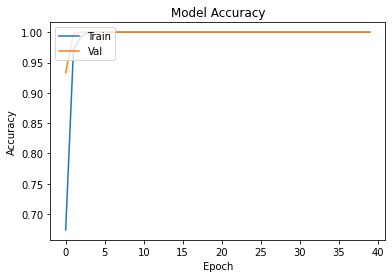

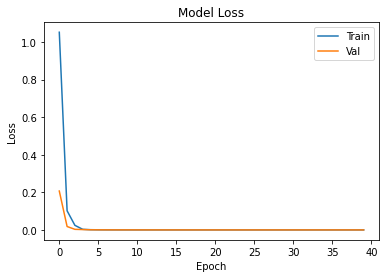

In [155]:
plot_acc(history)
plot_loss(history)

In [156]:
score = model.evaluate(X_t, y_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.097693024756154e-06
Test accuracy: 1.0


## Predictions

In [11]:
model = load_model('best_model.h5')

In [12]:
def visualize_prediction(x, class_index):
    plt.figure()
    plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    plt.xlabel(class_index)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [13]:
item = X_t[0]

result = model.predict(item.reshape(1, IMG_SIZE, IMG_SIZE, 3))
result

array([[3.9018407e-11, 1.5791700e-08, 1.0000000e+00]], dtype=float32)

In [14]:
predicted_class = MAP_CLASSES[np.argmax(result)]

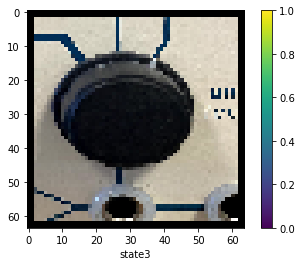

In [15]:
visualize_prediction(item, predicted_class)

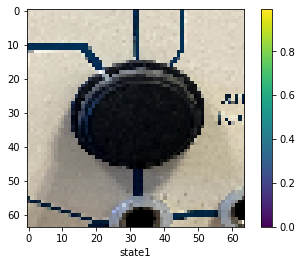

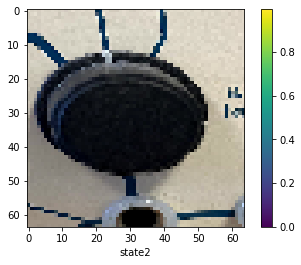

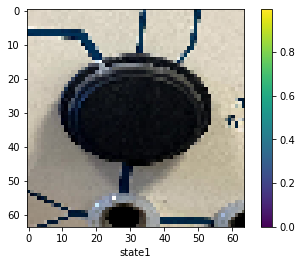

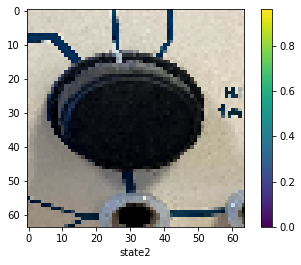

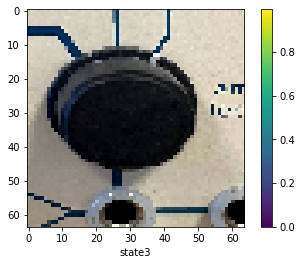

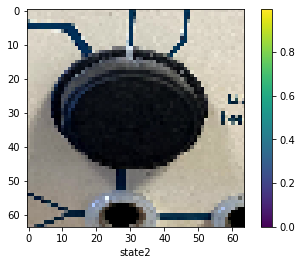

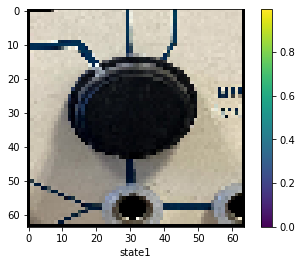

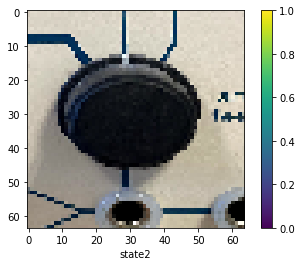

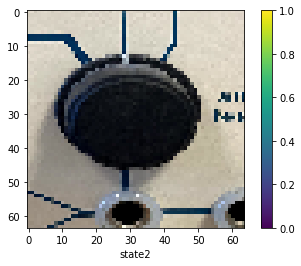

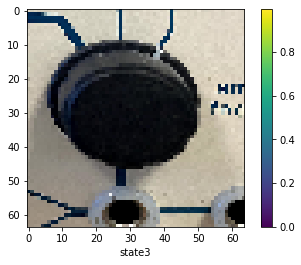

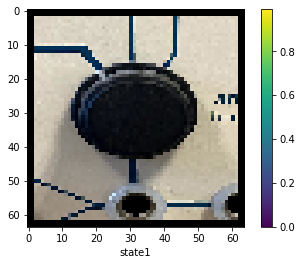

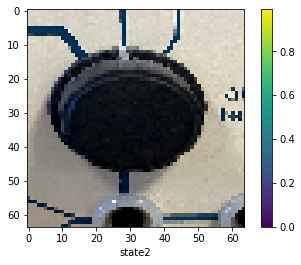

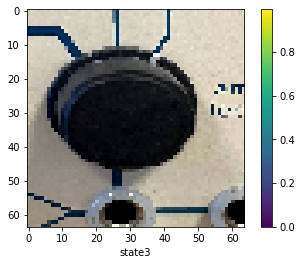

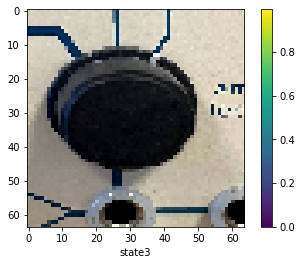

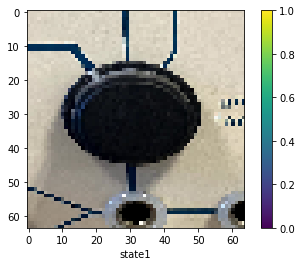

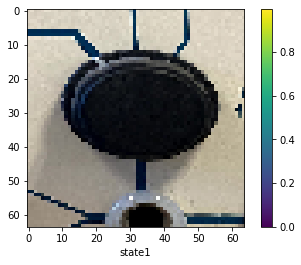

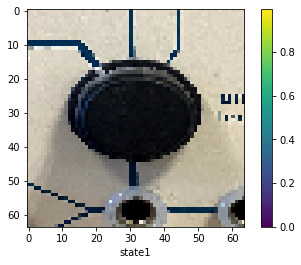

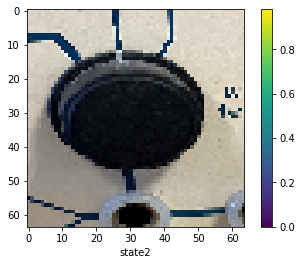

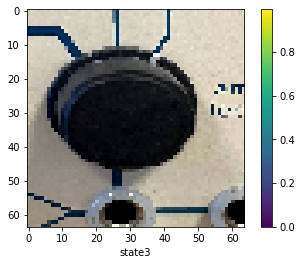

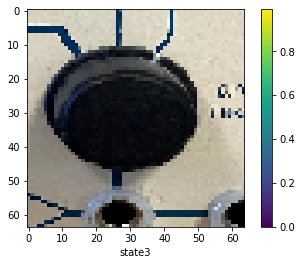

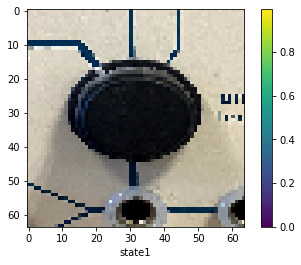

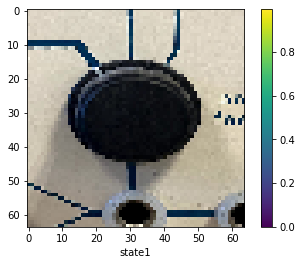

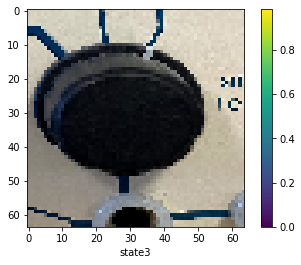

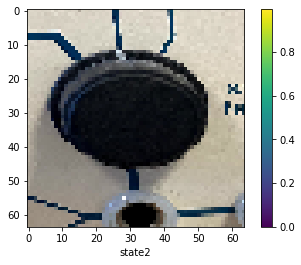

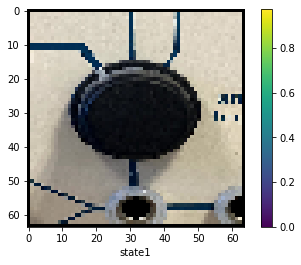

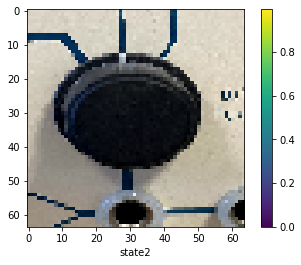

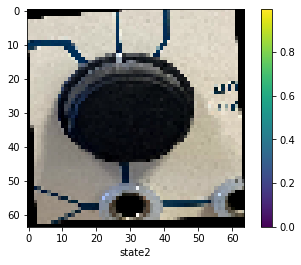

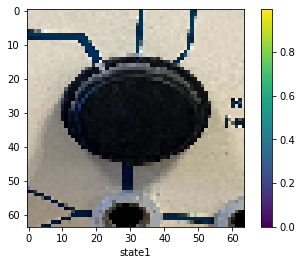

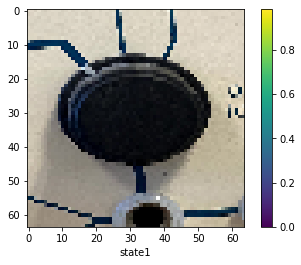

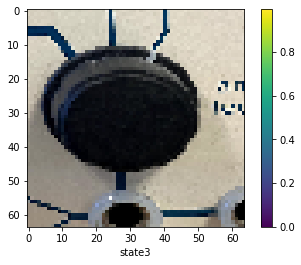

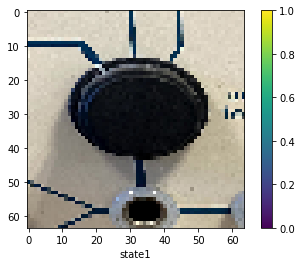

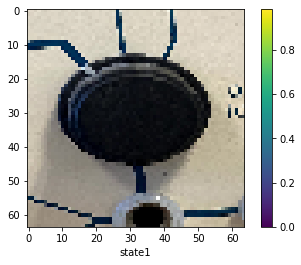

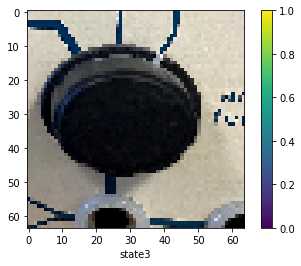

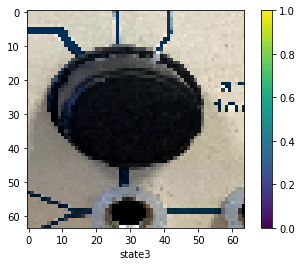

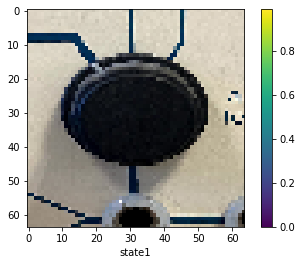

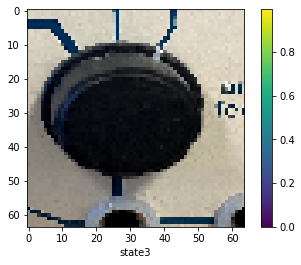

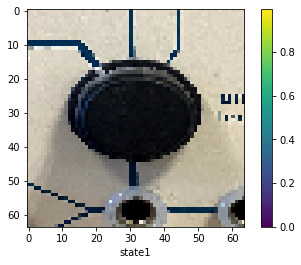

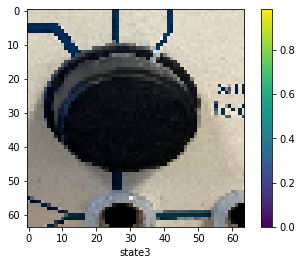

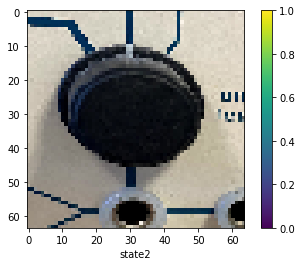

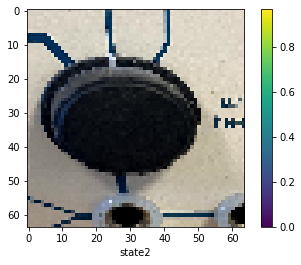

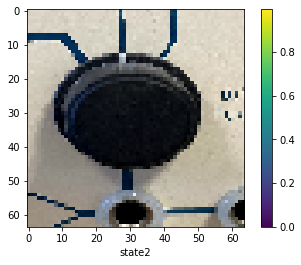

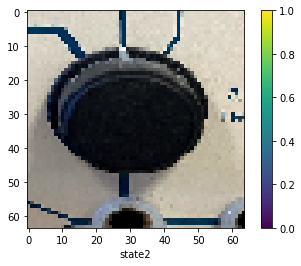

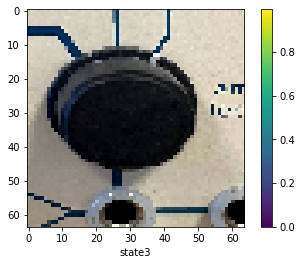

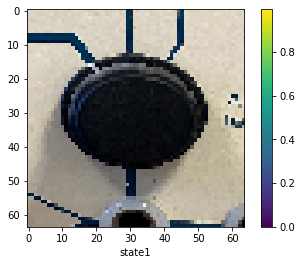

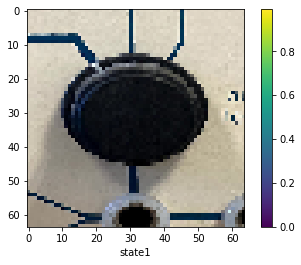

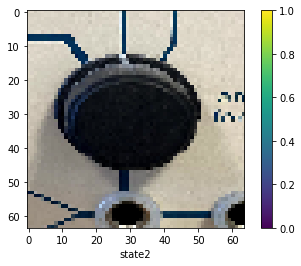

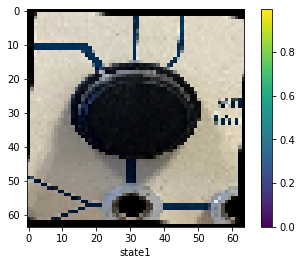

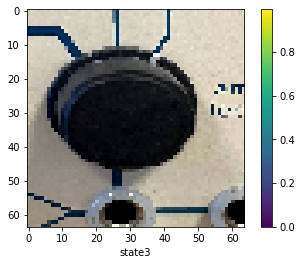

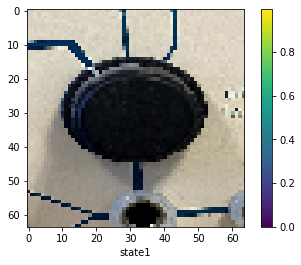

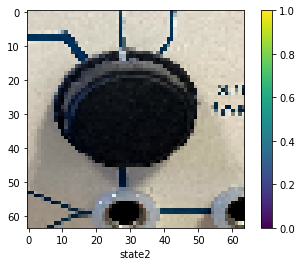

In [162]:
import random

for img in random.sample(list(X_t), 50):
    prediction = MAP_CLASSES[np.argmax(model.predict(img.reshape(1, IMG_SIZE,IMG_SIZE,3)))]
    visualize_prediction(img, prediction)